In [1]:
from __future__ import print_function
from __future__ import absolute_import

import warnings
import os
import random
import numpy as np
import threading
from PIL import Image
from skimage import io, color
from skimage.transform import rescale, resize, downscale_local_mean
import matplotlib.pyplot as plt
%matplotlib notebook

import keras
from keras.models import Model, load_model
from keras.optimizers import *
from keras.layers import *
from keras.layers.core import Lambda
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from slice import Slice
from colorizer import create_colorizer
from discriminator import create_discriminator
from batch_generators import DiscriminatorRealGenerator, ColorizerBatchGenerator, DiscriminatorFakeGenerator

# We need only the conv part of VGG
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
image_mean = (103.939, 116.779, 123.68)
greyscale_image_mean = np.mean(image_mean)

Using TensorFlow backend.


In [2]:
def make_trainable(layers, is_trainable):
    for l in layers:
        l.trainable = is_trainable
        
def create_GAN(generator, discriminator):
    generator_trainable_layers = [layer for layer in generator.layers if layer.trainable]
    discriminator_trainable_layers = [layer for layer in discriminator.layers if layer.trainable]

    network_input = Input(shape=(224, 224, 3))
    generator_output = generator(network_input)

    lightness = Slice(slice(0, 1), axis=3) (network_input)
    lab = concatenate([lightness, generator_output])
    network_output = discriminator(lab)

    GAN = Model(network_input, network_output)
    return GAN, generator_trainable_layers, discriminator_trainable_layers

In [3]:
colorizer, vgg = create_colorizer()
discriminator = create_discriminator()
gan, generator_trainable_layers, discriminator_trainable_layers = create_GAN(colorizer, discriminator)

discriminator.compile( loss='binary_crossentropy', optimizer=SGD(lr=0.01, momentum=0.01, nesterov=True) )
gan.compile(           loss='binary_crossentropy', optimizer=SGD(lr=0.01, momentum=0.01, nesterov=True) )

In [4]:
img = load_img('./dog.jpg', target_size=(224, 224))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

# res_first = first.predict([x], 1, verbose=1)
res_second = colorizer.predict([x], 1, verbose=1)

# print(res_first[0].shape)
print(res_second[0].shape)

1/1 [==============================] - 0s
(224, 224, 2)


# Train

In [5]:
# Define paths for train / validation / test datasets
train_root = '../coco/train2014/'
valid_root = '../coco/val2014/'
test_root = '../coco/test2014/'

train_image_paths = [train_root + item for item in os.listdir(train_root) if item.endswith('.jpg') ]
valid_image_paths = [valid_root + item for item in os.listdir(valid_root) if item.endswith('.jpg') ]
test_image_paths  = [test_root  + item for item in os.listdir(test_root)  if item.endswith('.jpg') ]

print( 'Train:', len(train_image_paths) )
print( 'Validation:', len(valid_image_paths) )
print( 'Test:', len(test_image_paths) )

Train: 82783
Validation: 40504
Test: 40775


In [6]:
batch_size = 37

# Train data generators
discriminator_real_generator = DiscriminatorRealGenerator(image_paths=train_image_paths, batch_size=batch_size, image_height=224, image_width=224)
discriminator_fake_generator = DiscriminatorFakeGenerator(image_paths=train_image_paths, batch_size=batch_size, image_height=224, image_width=224)
colorizer_generator = ColorizerBatchGenerator(image_paths=train_image_paths, batch_size=batch_size, image_height=224, image_width=224)

print('There are', len(train_image_paths) / batch_size, 'steps per one train epoch for one complete cycle')
print('There are', len(valid_image_paths) / batch_size, 'steps per one validation epoch for one complete cycle')

checkpoint_path="../checkpoints/model-{epoch:03d}-{loss:.4f}.model"
model_saver = ModelCheckpoint(filepath=checkpoint_path, monitor='loss', save_best_only=True, mode='min')
# tensorboard = TensorBoard(log_dir='/tmp/coloring/')


epochs = 77
steps_per_epoch = 500
validation_steps = 33
# callbacks = [tensorboard, model_saver]

There are 2237 steps per one train epoch for one complete cycle
There are 1094 steps per one validation epoch for one complete cycle


In [7]:
class LossVisualizer(object):
    def __init__(self, figsize=(12,8), last_iterations=5):
        self.fig, self.ax = plt.subplots(1,1)
        self.last_iterations = last_iterations


    def plot(self, fake_discriminator_loss, real_discriminator_loss, generator_loss):
        maxlen = max( len(fake_discriminator_loss), len(real_discriminator_loss), len(generator_loss) )
        while len(fake_discriminator_loss) < maxlen and fake_discriminator_loss: fake_discriminator_loss.append( fake_discriminator_loss[-1] )
        while len(real_discriminator_loss) < maxlen and fake_discriminator_loss: real_discriminator_loss.append( real_discriminator_loss[-1] )
        while len(generator_loss) < maxlen          and generator_loss:          generator_loss.append( generator_loss[-1] )
            
        fake_discriminator_loss = np.array(fake_discriminator_loss)
        real_discriminator_loss = np.array(real_discriminator_loss)
        generator_loss = np.array(generator_loss)
        
        fake_d = self.ax.plot(fake_discriminator_loss, color='red') 
        real_d = self.ax.plot(real_discriminator_loss, color='green')
        gen = self.ax.plot(generator_loss, color='blue')

#         self.fig.legend((fake_d, real_d, gen), ('fake_D', 'real_D', 'Gen'), 'upper right')
        self.fig.canvas.draw()

<IPython.core.display.Javascript object>


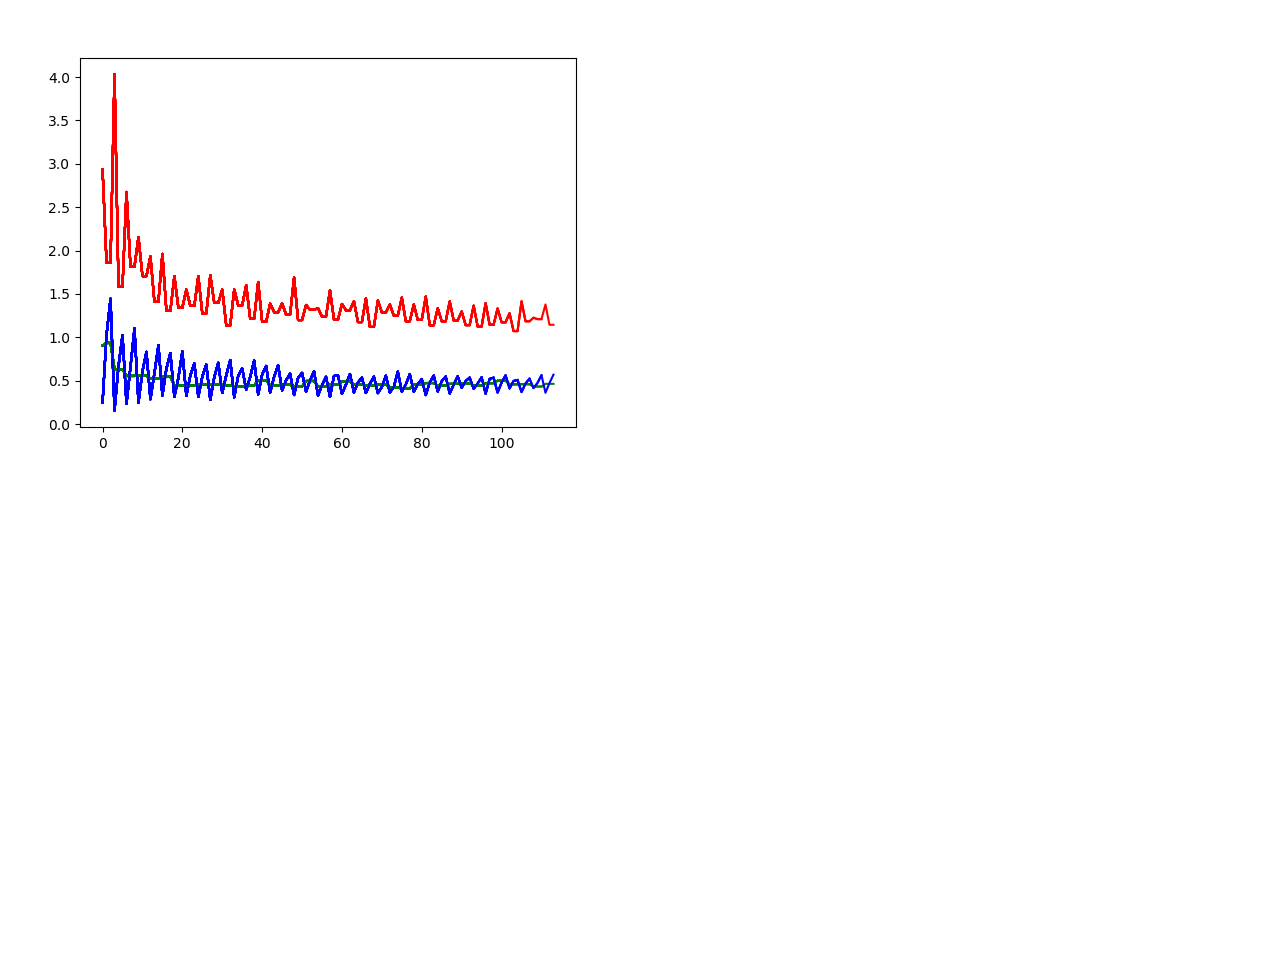

/home/martin/.miniconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [ ]:
from tqdm import tqdm_notebook as tqdm


fake_discriminator_loss = []
real_discriminator_loss = []
generator_loss = []
pattern = [0, 2, 1, 2, 1, 2]

for epoch in range(epochs):
    
    steps = pattern * ( steps_per_epoch / len(pattern) )
    t = tqdm( range(len(steps)) )
    loss_visualizer = LossVisualizer()

    for i in t:
        step = steps[i]
        
        # Make discriminator better on predicting real images
        if step == 0:
            net = discriminator                                   # Propagate the data only through discriminator
            make_trainable(discriminator_trainable_layers, True)  # make discriminator layers trainable
            make_trainable(generator_trainable_layers, False)     # we don't touch the generator
            batch_generator = discriminator_real_generator        # Images are real
            net_loss = real_discriminator_loss
                
        # Make discriminator better on detecting fake images
        elif step == 1:
            net = gan                                             # Propagate the data though the whole gan
            make_trainable(discriminator_trainable_layers, True)  # Train the discriminator
            make_trainable(generator_trainable_layers, False)     # But don't touch the generator as it's not his turn
            batch_generator = discriminator_fake_generator        # Images are fake
            net_loss = fake_discriminator_loss
        
        # Make colorizer better in fooling the discriminator
        else:
            net = gan                                             # Propagate the data through the whole gan
            make_trainable(discriminator_trainable_layers, False) # Don't train the discriminator when fooling it
            make_trainable(generator_trainable_layers, True)      # Train only the generator
            batch_generator = colorizer_generator                 # Lets fool the discriminator
            net_loss = generator_loss

            
        # Train on the current batch
        batch = batch_generator.next()
        x, y = batch
        loss = net.train_on_batch(x, y)
        net_loss.append(loss)
        
        if i % len(pattern) == 0:
            loss_visualizer.plot(fake_discriminator_loss, real_discriminator_loss, generator_loss)
        # Display progress
        t.set_description('Train batch %i' % i)
        t.set_postfix(loss=loss, step=step)
    
    gan.save('../checkpoints/gan-' + str(epoch) + '.model')
    colorizer.save('../checkpoints/colorizer-' + str(epoch) + '.model')
    discriminator.save('../checkpoints/discriminator-' + str(epoch) + '.model')

# Evaluate

In [ ]:
path = './puma.jpg' # random.choice(test_image_paths)

rgb = io.imread(path)
rgb = resize(rgb, output_shape=(224, 224, 3))
image_gray = load_img(path, grayscale=True, target_size=(224, 224))
lab = color.rgb2lab(rgb)

inp = np.zeros((224, 224, 3))
inp[:,:,0] = image_gray - greyscale_image_mean
inp[:,:,1] = image_gray - greyscale_image_mean
inp[:,:,2] = image_gray - greyscale_image_mean

In [ ]:
%matplotlib inline
colorizer = load_model('../checkpoints/colorizer-0.model')
out = colorizer.predict(np.array([inp]), batch_size=1)[0]

img = np.zeros((224, 224, 3))
img[...,0] = lab[...,0]
img[...,1:] = out

plt.imshow(color.lab2rgb(img))

# Experiments